## Import libraires and data, set up stuff

In [1]:
import anndata as ad
import scanpy as sc
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import os

from IPython.display import Markdown, display
from IPython.core.display import display, HTML
from os import environ

sns.set_context('poster')
plt.style.use('seaborn-darkgrid')

display(HTML("<style>.container { width:90% !important; }</style>"))
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80) #resolution

/scratch/usertmp/ipykernel_24892/4071164959.py:11: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML
/scratch/usertmp/ipykernel_24892/4071164959.py:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


## Functions

In [2]:
def get_adata(path_to_mtx,samples):
    sample = samples[0]

    adata = sc.read_10x_mtx(path_to_mtx[0],cache=True)
    adata.obs_names = [ sample+"_"+x.split("-")[0] for x in adata.obs_names ]
    adata.obs["DATASET"] = sample

    for index,file in enumerate(path_to_mtx[1:]):
        sample = samples[index+1]

        adata_new = sc.read_10x_mtx(file,cache=True)
        adata_new.obs_names = [ sample+"_"+x.split("-")[0] for x in adata_new.obs_names ]
        adata_new.obs["DATASET"] = sample

        adata = adata.concatenate(adata_new,index_unique=None)
        del(adata_new)
        
    return adata

In [3]:
def get_adata_velocyto(path_to_mtx,path_to_velocyto,samples):
    sample = samples[0]

    adata = sc.read_10x_mtx(path_to_mtx[0],cache=True)
    ldata = sc.read_loom(path_to_velocyto[0])
    adata = scv.utils.merge(adata,ldata)
    adata.obs_names = [ sample+"_"+x.split("-")[0] for x in adata.obs_names ]
    adata.obs["DATASET"] = sample

    for index,file in enumerate(path_to_mtx[1:]):
        sample = samples[index+1]

        adata_new = sc.read_10x_mtx(file,cache=True)
        ldata = sc.read_loom(path_to_velocyto[idx+1])
        adata_new = scv.utils.merge(adata_new,ldata)
        adata_new.obs_names = [ sample+"_"+x.split("-")[0] for x in adata_new.obs_names ]
        adata_new.obs["DATASET"] = sample

        adata = adata.concatenate(adata_new,index_unique=None)
        del(adata_new)
        
    return adata

In [133]:
def add_chroms(adata,chroms_df):
    chroms_df = chroms_df[chroms_df["gene_id"].isin(adata.var_names)].copy()
    adata = adata[:,chroms_df["gene_id"]].copy()
    adata.var["chromosome"] = chroms_df["CHROM"].tolist()
    return adata

In [134]:
def get_unspliced_spliced(adata,adata_spliced,adata_unspliced):
    adata_spliced = adata_spliced[adata.obs_names,:].copy()
    adata_spliced = adata_spliced[:,adata.var_names].copy()
    adata.layers["spliced"] = adata_spliced.X
    
    adata_unspliced = adata_unspliced[adata.obs_names,:].copy()
    adata_unspliced = adata_unspliced[:,adata.var_names].copy()
    adata.layers["unspliced"] = adata_unspliced.X
    
    return adata

In [135]:
def get_ampl_counts(adata):
    amplicons = [x for x in adata.var_names if x.startswith("amplicon")]
    sc_genes = [x for x in adata.var_names if not x.startswith("amplicon")]
    adata_sc = adata[:,sc_genes].copy()
    adata_amplicons = adata[:,amplicons].copy()
    adata_amplicons.var["family"] = ["_".join(x.split("_")[:-1]) for x in amplicons]
    family_counts_dict = {}
    for x in np.unique(adata_amplicons.var["family"]):
        family_counts_dict[x] = np.sum(adata_amplicons[:,adata_amplicons.var["family"]==x].X,axis=1).A1.tolist()
    family_counts_df = pd.DataFrame(family_counts_dict,index=adata_amplicons.obs_names)
    adata_amplicons_fam = sc.AnnData(family_counts_df)
    print(family_counts_dict.keys())
    adata_new = ad.concat([adata_sc,adata_amplicons_fam],axis=1,join='outer',merge="only")
    return adata_new

In [130]:
def plotQC(adata):
    """
    Function for plotting QC values. 
    Needs to run preprocess.calculateQC first.
    """
    from scipy.sparse import issparse
    import scanpy as sc
    import matplotlib.pyplot as plt
    from matplotlib import rcParams
    import pandas as pd
    import numpy as np
    import seaborn as sns


    df=pd.DataFrame(index=adata.obs_names)
    df['total_counts'] = adata.obs['total_counts']
    df['n_genes_per_cell'] = adata.obs['n_genes_by_counts']
    if 'percent_mito' in adata.obs_keys():
        df['percent_mito'] = adata.obs['percent_mito']
    else:
        df['percent_mito'] = np.zeros(adata.shape[0])

    plt.rcParams['figure.figsize']=(20,20)
    f, ax = plt.subplots(3,2)

    sns.scatterplot(x='total_counts', y='n_genes_per_cell', hue='percent_mito', data=df, ax=ax[0,0])
    ax[0,0].set_title('UMI vs GENES plot - percent mito genes')

    if 'prop_spl' in adata.obs_keys():
        df['rate_spliced'] = adata.obs['prop_spl']
    else:
        df['rate_spliced'] = np.zeros(adata.shape[0])
    sns.scatterplot(x='total_counts', y='n_genes_per_cell', hue='rate_spliced', data=df, ax=ax[0,1])
    ax[0,1].set_title('UMI vs GENES plot - spliced proportions')

    sns.distplot(df['total_counts'], ax=ax[1,0])
    ax[1,0].set_title('UMI counts per cell')

    sns.distplot(df['n_genes_per_cell'], ax=ax[1,1])
    ax[1,1].set_title('Genes per cell')

    df['counts_over_genes'] = df['total_counts']/df['n_genes_per_cell']
    sns.scatterplot(x='total_counts', y='counts_over_genes', hue='percent_mito', data=df, ax=ax[2,0])
    ax[2,0].set_title('UMI vs UMI/GENES ratio plot - percent MT genes')
    sns.scatterplot(x='total_counts', y='counts_over_genes', hue='rate_spliced', data=df, ax=ax[2,1])
    ax[2,1].set_title('UMI vs UMI/GENES ratio plot - spliced proportions')

    plt.rcParams['figure.figsize']=(6,6)

In [206]:
def scrublet(adata, expected_rate=0.06, doublet_score=None):
    import scrublet as scr
    import numpy as np
    scrub = scr.Scrublet(adata.X, expected_doublet_rate=expected_rate)

    doublet_scores, predicted_doublets = scrub.scrub_doublets(min_counts=2, min_cells=3, min_gene_variability_pctl=85, n_prin_comps=30)


    adata.obs['doublet_scores']=doublet_scores
    adata.obs['predicted_doublets']=predicted_doublets

    adata.obs['predicted_doublets'] = adata.obs['doublet_scores']>doublet_score
    print('Nr of predicted doublets ', np.sum(adata.obs['predicted_doublets']))
    print('Doublets indices saved in adata.obs["predicted_doublets"]')

    scrub.plot_histogram()

## Paths

### Samples, species

In [5]:
samples="SN111,SN052,SN011,SN007,SN142".split(",") 
sp = ["HUM", "GOR", "CHIMP", "BON", "MAC"]

sp_sample_dict = {
	"HUM":["SN142","SN111","SN052","SN011","SN007"], "GOR":["MB_n_B4"], "CHIMP":["Carl", "SN074", "SN112", "SN193"], "BON":["SN219", "SN224"], "MAC":["SN116", "SN143"]
}

### Inputs

In [137]:
gene_annotation = f'/home/mtxellrb/primatescrna/UPDATED/HEID_DATA_single_annot/{sp}/ref_data/genes_amplicons_starsolo.gtf'
genes_chroms= f'/home/mtxellrb/primatescrna/UPDATED/HEID_DATA_single_annot/{sp}/ref_data/summary_chroms.tsv'

path_to_mapping = f'/home/mtxellrb/primatescrna/UPDATED/HEID_DATA_single_annot/{sp}/mapping/'
path_to_mapping_velo = f'/home/mtxellrb/primatescrna/UPDATED/HEID_DATA_single_annot/{sp}/mapping/'

path_to_mtx_starsolo_multimap_list = []
path_to_mtx_starsolo_list = []
path_to_mtx_starsolo_velocyto_list = []
samples_adata = []

for sample in samples:
    path_to_mtx_starsolo_multimap_list.append(f'{path_to_mapping}{sample}/starsolo/{sample}/velocyto/Solo.out/GeneFull/raw/to_scanpy/')
    path_to_mtx_starsolo_list.append(f'{path_to_mapping}{sample}/starsolo/{sample}/velocyto/Solo.out/GeneFull/filtered')
    path_to_mtx_starsolo_velocyto_list.append(f'{path_to_mapping_velo}{sample}/starsolo/{sample}/velocyto/Solo.out/Velocyto/raw/')

### Outputs

In [138]:
path_out = f'/home/mtxellrb/primatescrna/UPDATED/HEID_DATA_single_annot/{sp}/adata/'

if not os.path.exists(path_out):
    os.makedirs(path_out)

adata_out = f'{path_out}/preproc_1_starsolo_multimap.h5ad'

In [139]:
palette_dict = {"Elongated_spermatids":'#0173B2',"Round_spermatids":'#FF7C00',"Spermatocytes":"green","Spermatogonia":"red"}

#### Get adata

Here we read the UMI matrices for all samples and create adata_mm (containing multimapping reads) and adata_s (only uniquely mapping reads). Starsolo only filters out empty cells for uniquely mapping reads, thus we only keep cells found in adata_s.

In [141]:
adata_mm = get_adata(path_to_mtx_starsolo_multimap_list,samples_adata)
adata_s = get_adata(path_to_mtx_starsolo_list,samples_adata)

... reading from cache file cache/home-mtxellrb-primatescrna-UPDATED-HEID_DATA_single_annot-HUM-mapping-SN111-starsolo-SN111-velocyto-Solo.out-GeneFull-raw-to_scanpy-matrix.h5ad
... reading from cache file cache/home-mtxellrb-primatescrna-UPDATED-HEID_DATA_single_annot-HUM-mapping-SN052-starsolo-SN052-velocyto-Solo.out-GeneFull-raw-to_scanpy-matrix.h5ad
... reading from cache file cache/home-mtxellrb-primatescrna-UPDATED-HEID_DATA_single_annot-HUM-mapping-SN011-starsolo-SN011-velocyto-Solo.out-GeneFull-raw-to_scanpy-matrix.h5ad
... reading from cache file cache/home-mtxellrb-primatescrna-UPDATED-HEID_DATA_single_annot-HUM-mapping-SN007-starsolo-SN007-velocyto-Solo.out-GeneFull-raw-to_scanpy-matrix.h5ad
... reading from cache file cache/home-mtxellrb-primatescrna-UPDATED-HEID_DATA_single_annot-HUM-mapping-SN142-starsolo-SN142_highseq-velocyto-Solo.out-GeneFull-raw-to_scanpy-matrix.h5ad
... reading from cache file cache/home-mtxellrb-primatescrna-UPDATED-HEID_DATA_single_annot-HUM-mappin

Here we filter out empty cells (based on EmptyDrops)

In [142]:
adata_mm = adata_mm[adata_s.obs_names,:].copy()
del(adata_s)

Here we sum up all multicopy/ampliconic gene counts for the same multicopy/ampliconic gene family

In [147]:
adata_mm = get_ampl_counts(adata_mm)

dict_keys(['amplicon_chrX_ARMCX6', 'amplicon_chrX_BIG_FAMILY_A', 'amplicon_chrX_BIG_FAMILY_B', 'amplicon_chrX_CENPVL1/2/3', 'amplicon_chrX_CPXCR1', 'amplicon_chrX_CSAG1/2/3', 'amplicon_chrX_CT45A1/2/3//6/7/8/9/10', 'amplicon_chrX_CT47A1/2/3/4/5/6/7/8/9/10/11/12/B1', 'amplicon_chrX_CT55', 'amplicon_chrX_CT83', 'amplicon_chrX_CTAG1A/1B/2', 'amplicon_chrX_CXorf49/B', 'amplicon_chrX_CXorf51A/B', 'amplicon_chrX_DDX53', 'amplicon_chrX_DMRTC1/B/FAM236A/B/C/D', 'amplicon_chrX_EOLA1/2/HSFX3/4', 'amplicon_chrX_ETD1/B/ZNF75D', 'amplicon_chrX_F8/F8A1/2/3/H2AB1/2/3', 'amplicon_chrX_FAAH2/SPIN2A/B', 'amplicon_chrX_FAM156A/B', 'amplicon_chrX_FAM47A/B/C', 'amplicon_chrX_G6PD/IKBKG', 'amplicon_chrX_GAGE10/1/2A/13/12B/12C/12D/12E/12F/12G/12H/12J', 'amplicon_chrX_H2BW2', 'amplicon_chrX_HSFX1/2', 'amplicon_chrX_IL3RA/P2RY8/SLC25A6', 'amplicon_chrX_MAGEA12/A2/A2B/A3/A6', 'amplicon_chrX_MAGEA4', 'amplicon_chrX_MAGEA9/9B', 'amplicon_chrX_MAGEB6', 'amplicon_chrX_MAGEC1', 'amplicon_chrX_MAGED4/B', 'amplicon_ch

In [148]:
amplicons = [x for x in adata_mm.var_names if x.startswith("amplicon")]

4.263068743236249


Here we read unspliced and spliced matrices

In [149]:
path_to_unspliced = [x+"unspliced/" for x in path_to_mtx_starsolo_velocyto_list]
path_to_spliced = [x+"spliced/" for x in path_to_mtx_starsolo_velocyto_list]

In [151]:
unspliced = get_adata(path_to_unspliced,samples_adata)
spliced = get_adata(path_to_spliced,samples_adata)

... reading from cache file cache/home-mtxellrb-primatescrna-UPDATED-HEID_DATA_single_annot-HUM-mapping-SN111-starsolo-SN111-velocyto-Solo.out-Velocyto-raw-unspliced-matrix.h5ad
... reading from cache file cache/home-mtxellrb-primatescrna-UPDATED-HEID_DATA_single_annot-HUM-mapping-SN052-starsolo-SN052-velocyto-Solo.out-Velocyto-raw-unspliced-matrix.h5ad
... reading from cache file cache/home-mtxellrb-primatescrna-UPDATED-HEID_DATA_single_annot-HUM-mapping-SN011-starsolo-SN011-velocyto-Solo.out-Velocyto-raw-unspliced-matrix.h5ad
... reading from cache file cache/home-mtxellrb-primatescrna-UPDATED-HEID_DATA_single_annot-HUM-mapping-SN007-starsolo-SN007-velocyto-Solo.out-Velocyto-raw-unspliced-matrix.h5ad
... reading from cache file cache/home-mtxellrb-primatescrna-UPDATED-HEID_DATA_single_annot-HUM-mapping-SN142-starsolo-SN142_highseq-velocyto-Solo.out-Velocyto-raw-unspliced-matrix.h5ad
... reading from cache file cache/home-mtxellrb-primatescrna-UPDATED-HEID_DATA_single_annot-HUM-mappin

Here we sum up all multicopy/ampliconic unspliced/spliced gene counts for the same multicopy/ampliconic gene family

In [152]:
unspliced = get_ampl_counts(unspliced)
spliced = get_ampl_counts(spliced)

dict_keys(['amplicon_chrX_ARMCX6', 'amplicon_chrX_BIG_FAMILY_A', 'amplicon_chrX_BIG_FAMILY_B', 'amplicon_chrX_CENPVL1/2/3', 'amplicon_chrX_CPXCR1', 'amplicon_chrX_CSAG1/2/3', 'amplicon_chrX_CT45A1/2/3//6/7/8/9/10', 'amplicon_chrX_CT47A1/2/3/4/5/6/7/8/9/10/11/12/B1', 'amplicon_chrX_CT55', 'amplicon_chrX_CT83', 'amplicon_chrX_CTAG1A/1B/2', 'amplicon_chrX_CXorf49/B', 'amplicon_chrX_CXorf51A/B', 'amplicon_chrX_DDX53', 'amplicon_chrX_DMRTC1/B/FAM236A/B/C/D', 'amplicon_chrX_EOLA1/2/HSFX3/4', 'amplicon_chrX_ETD1/B/ZNF75D', 'amplicon_chrX_F8/F8A1/2/3/H2AB1/2/3', 'amplicon_chrX_FAAH2/SPIN2A/B', 'amplicon_chrX_FAM156A/B', 'amplicon_chrX_FAM47A/B/C', 'amplicon_chrX_G6PD/IKBKG', 'amplicon_chrX_GAGE10/1/2A/13/12B/12C/12D/12E/12F/12G/12H/12J', 'amplicon_chrX_H2BW2', 'amplicon_chrX_HSFX1/2', 'amplicon_chrX_IL3RA/P2RY8/SLC25A6', 'amplicon_chrX_MAGEA12/A2/A2B/A3/A6', 'amplicon_chrX_MAGEA4', 'amplicon_chrX_MAGEA9/9B', 'amplicon_chrX_MAGEB6', 'amplicon_chrX_MAGEC1', 'amplicon_chrX_MAGED4/B', 'amplicon_ch

Here we add unspliced and spliced counts to the adata structure

In [163]:
adata_mm = get_unspliced_spliced(adata_mm,spliced,unspliced)

In [169]:
del(spliced)
del(unspliced)

In [164]:
amplicons = [x for x in adata_mm.var_names if x.startswith("amplicon")]

#### Get chroms

In [153]:
gene_annot = pd.read_csv(gene_annotation,sep="\t",names=["chrom","source","feature","start","end","extra_1","strand","extra_2","info"])[["chrom","info"]]
gene_annot["gene_id"] = [ x.split("gene_name")[1].split('"')[1] if re.search("gene_name",x) else x.split("gene_id")[1].split('"')[1] for x in gene_annot["info"] ]
gene_annot["gene_id"] = ["_".join(x.split("_")[:-1]) if re.search("amplicon",x) else x for x in gene_annot["gene_id"]]

gene_annot = gene_annot[["chrom","gene_id"]].drop_duplicates()

dat = pd.read_csv(genes_chroms, sep='\t')[["CHROM","REFSEQ_CHROM"]]
gene_annot = pd.merge(gene_annot,dat,left_on="chrom",right_on="REFSEQ_CHROM").drop_duplicates(subset=["gene_id","CHROM"])

In [155]:
df = pd.DataFrame(np.unique(gene_annot["gene_id"],return_counts=True)).T
df.columns = ["gene","counts"]

In [158]:
dup_genes = gene_annot[gene_annot["gene_id"].isin(df[df["counts"]>1]["gene"])]

In [159]:
gene_annot = gene_annot.drop(index=dup_genes.index)
adata_mm = adata_mm[:,[x for x in adata_mm.var_names if not x in dup_genes["gene_id"]]].copy()

In [162]:
adata_mm = add_chroms(adata_mm,gene_annot)

#### Exclude genes in PAR region

In [165]:
genes_par = pd.read_csv(f'/home/mtxellrb/primatescrna/UPDATED/PAR_regions/{sp}/genes_PAR.tsv',sep="\t",names=["genes_par"])["genes_par"].tolist()

In [166]:
chroms = [ "PAR" if x in genes_par else adata_mm.var["chromosome"][idx] for idx,x in enumerate(adata_mm.var_names)  ]

In [167]:
adata_mm.var["chromosome"] = chroms

## Quality control

In [170]:
adata_mm.obs["total_counts"] = np.sum(adata_mm.X,axis=1)
adata_mm.obs["n_genes_by_counts"] = np.count_nonzero(np.array(adata_mm.X.todense()),axis=1)

In [171]:
mito_genes = [ x for idx,x in enumerate(adata_mm.var_names) if adata_mm.var["chromosome"][idx] == "MT" ]
adata_mm.obs["percent_mito"] = np.sum(adata_mm[:,mito_genes].X,axis=1).A1 / np.array(adata_mm.obs["total_counts"])

In [172]:
adata_mm.obs["prop_unspl"] = np.sum(adata_mm.layers["unspliced"],axis=1).A1 / (np.sum(adata_mm.layers["unspliced"],axis=1).A1 + np.sum(adata_mm.layers["spliced"],axis=1).A1)
adata_mm.obs["prop_spl"] = 1 - adata_mm.obs["prop_unspl"]

In [174]:
adata_mm.shape

(21253, 34315)

### Highly expressed genes

normalizing counts per cell
    finished (0:00:00)


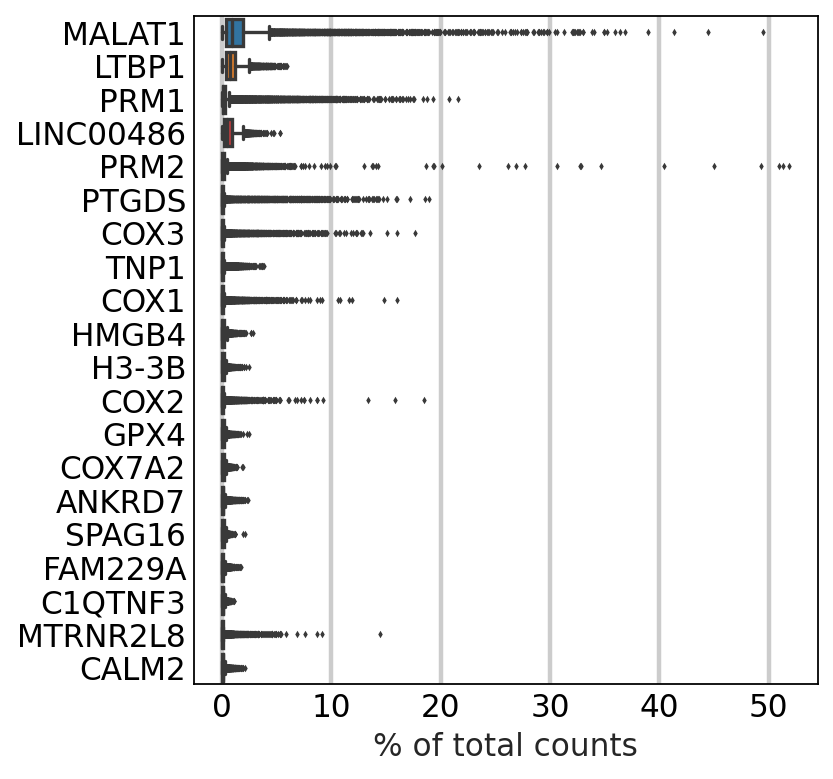

In [176]:
sc.pl.highest_expr_genes(adata_mm, n_top=20, )

### mtDNA

<AxesSubplot:xlabel='percent_mito', ylabel='Density'>

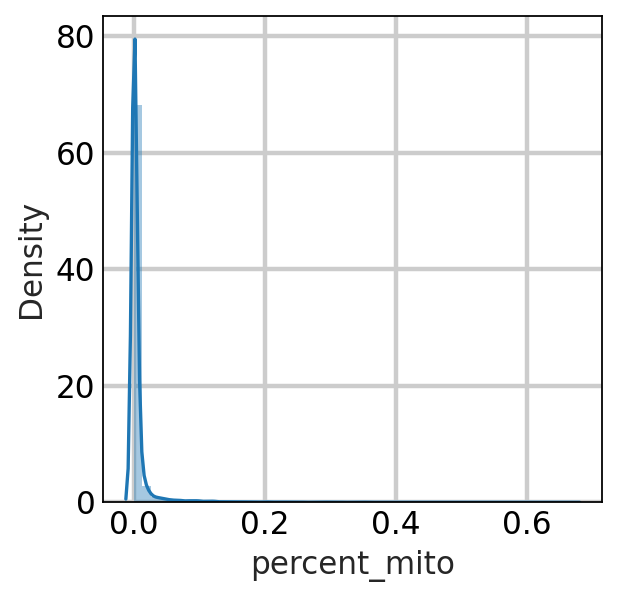

In [180]:
sns.distplot(adata_mm.obs["percent_mito"])

In [181]:
# remove high MT perc
adata_mm = adata_mm[adata_mm.obs["percent_mito"]<0.2].copy()

In [183]:
adata_mm.shape

(21135, 34315)

### Spliced proportions filter

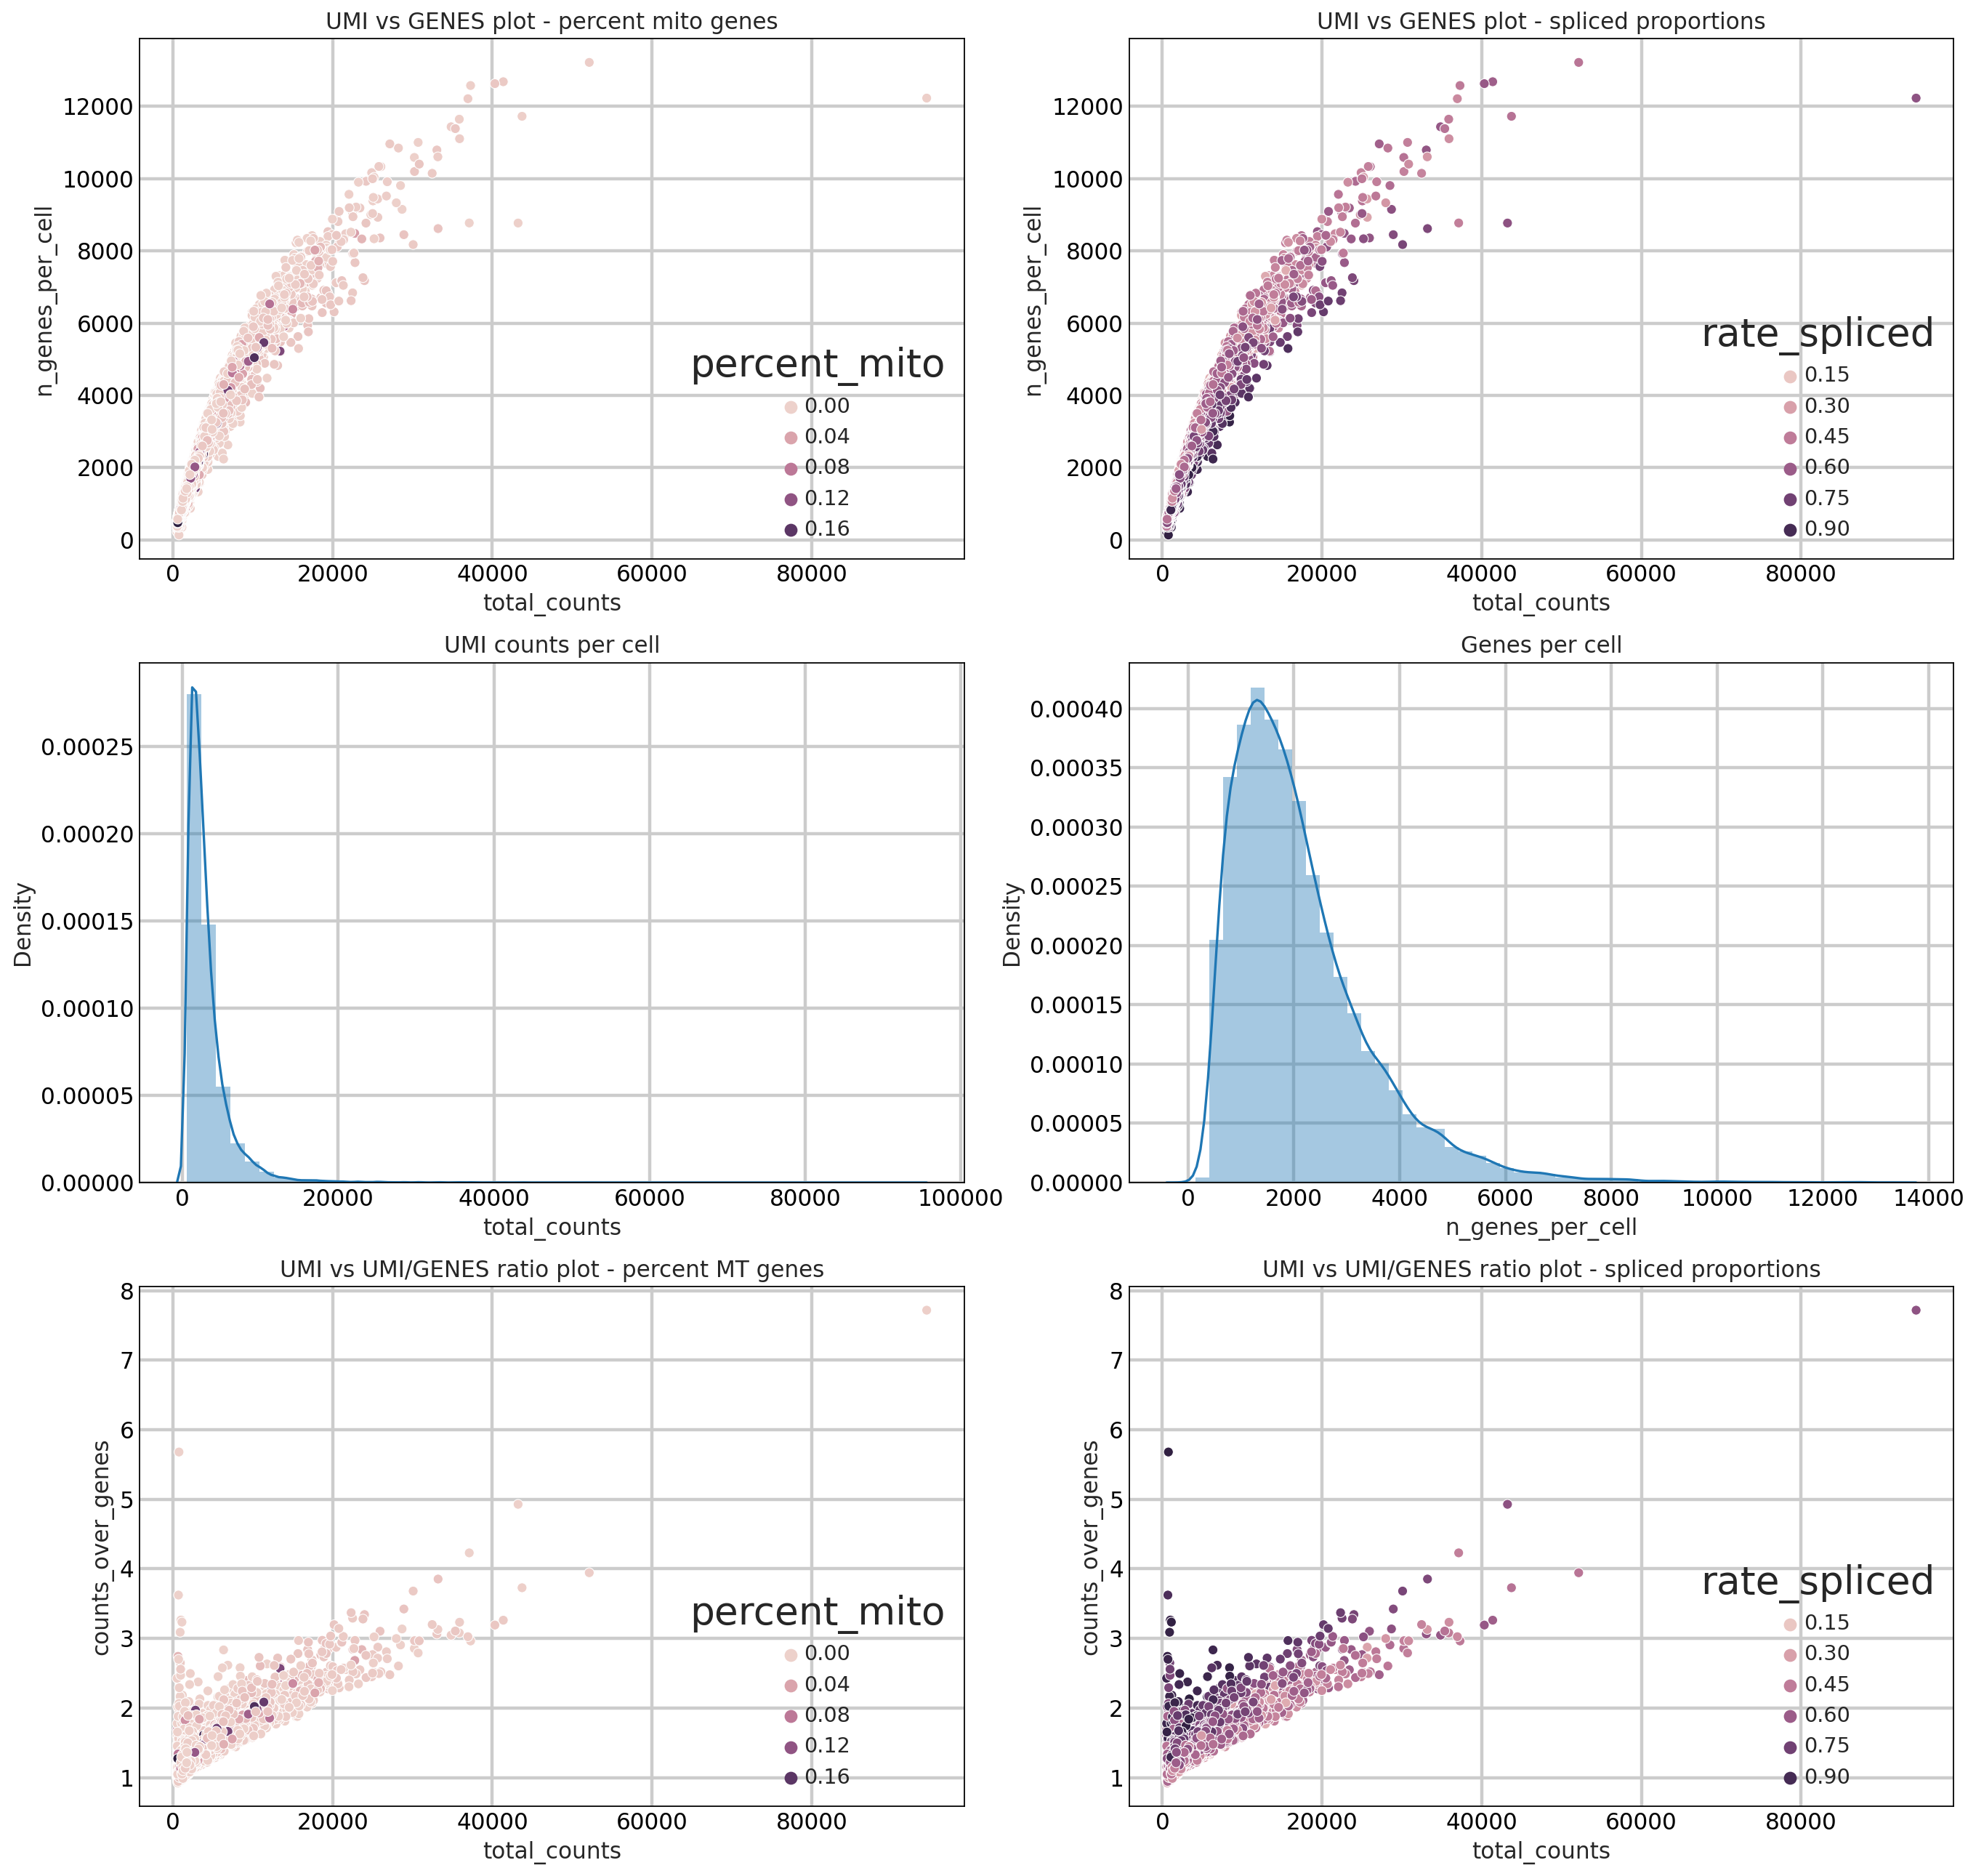

In [189]:
#do some plots of quality measures
plotQC(adata_mm)

<AxesSubplot:xlabel='prop_spl', ylabel='Count'>

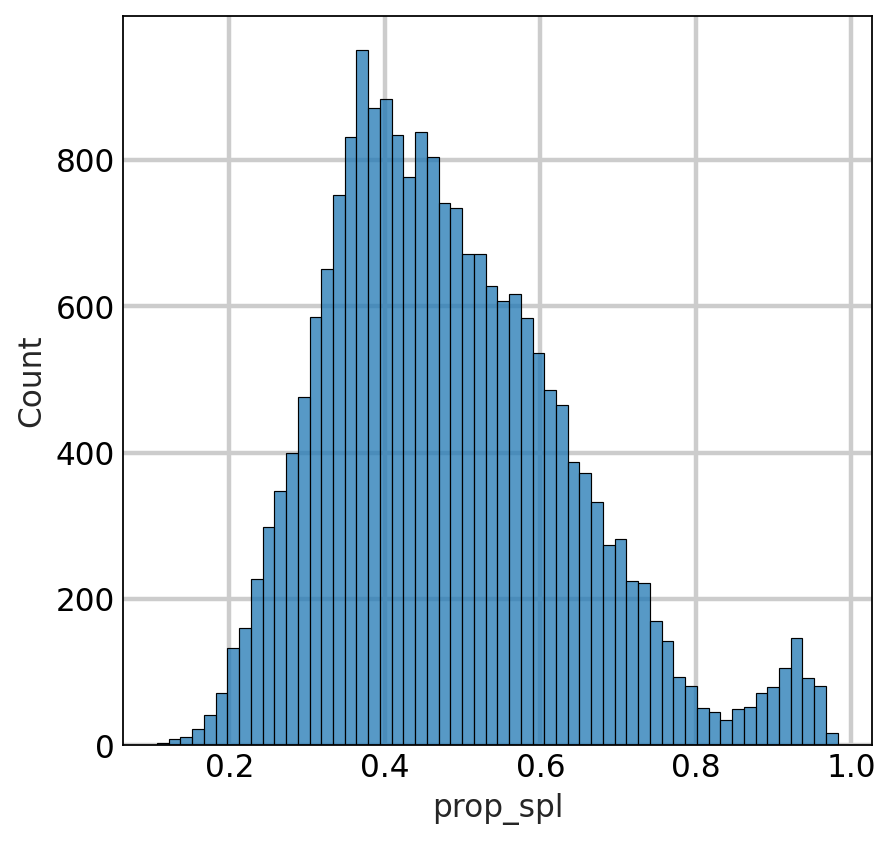

In [191]:
#look at spliced proportions in detail to decide what to remove
plt.rcParams["figure.figsize"] = (6,6)
sns.histplot(adata_mm.obs['prop_spl'])

In [194]:
#spliced proportions filtering. One can avoid being too rough in filtering, the later filtering based on PCA decomposition is going to help removing remaining outliers with spliced proportions out of range (since those cells also show other abnormal quality measures).
prop_spl = .5
print('Removing',adata_mm[adata_mm.obs['prop_spl']>=prop_spl].shape[0],'cells with equal or more than',prop_spl,'spliced proportion')
adata_mm=adata_mm[adata_mm.obs['prop_spl']<prop_spl].copy()

Removing 8656 cells with equal or more than 0.5 spliced proportion


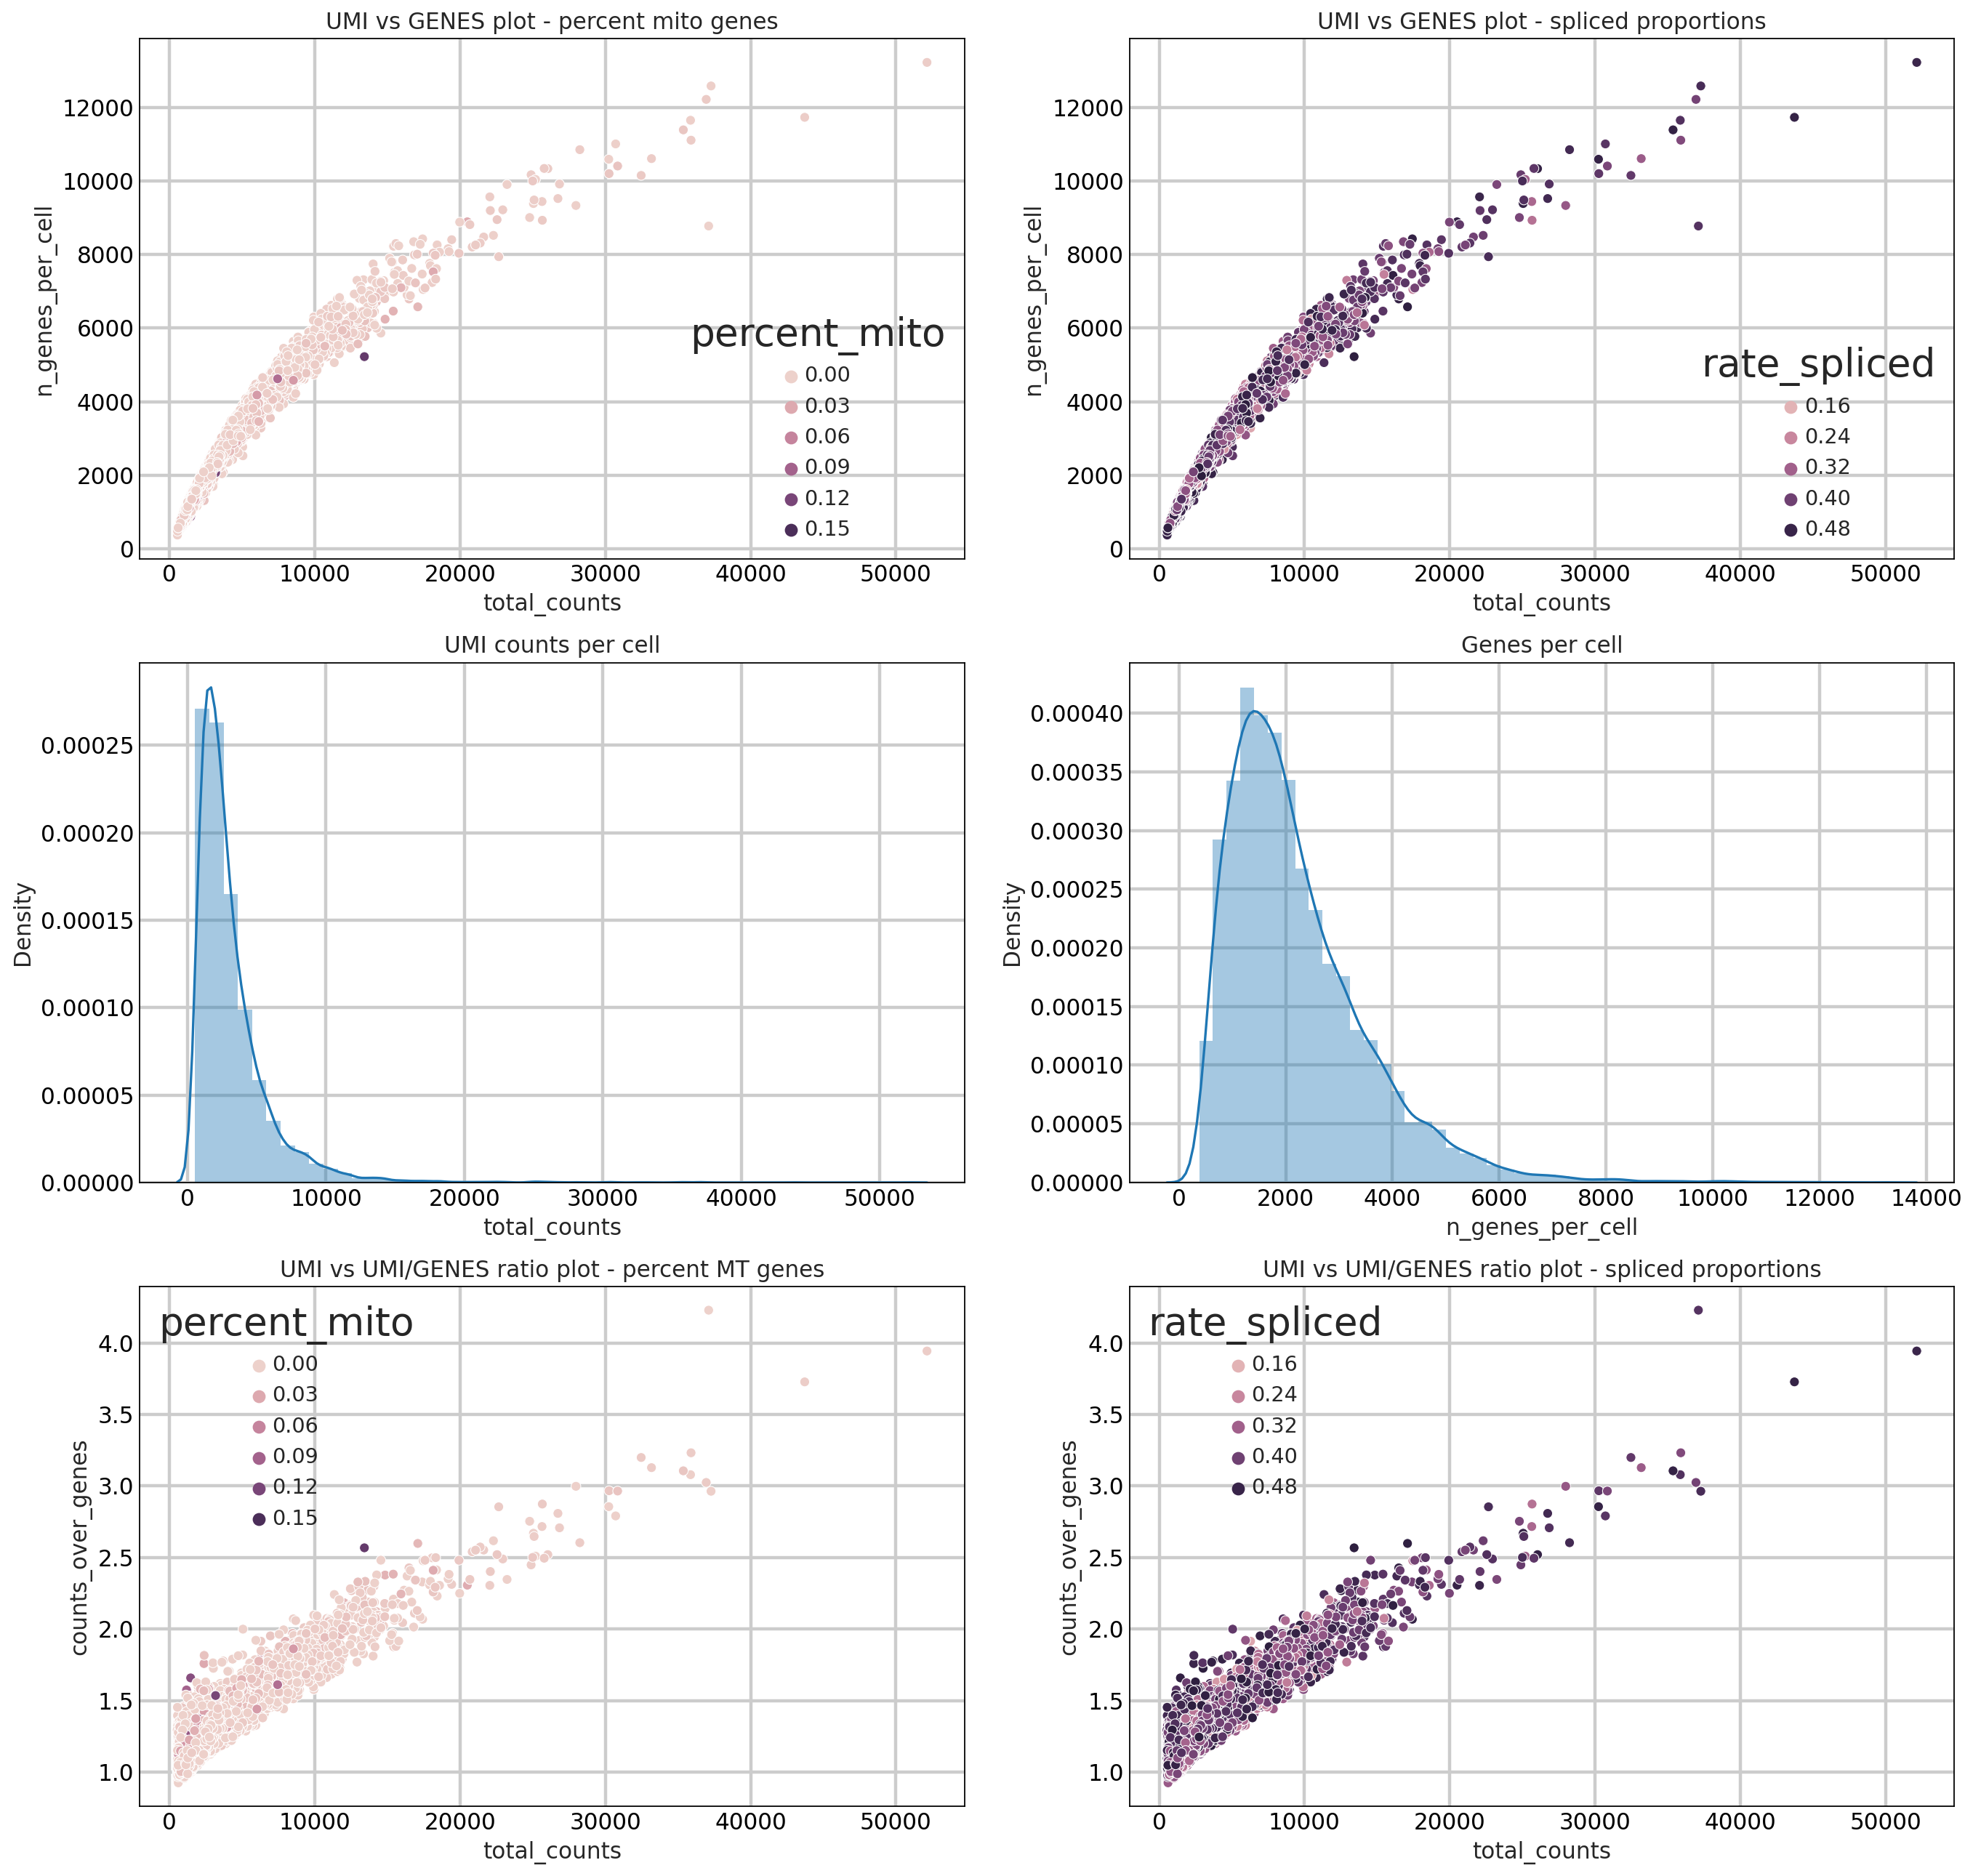

In [199]:
#how it does look like after filtering by spliced proportions
plotQC(adata_mm)

### Filter out genes seen in less than few cells

In [203]:
sc.pp.filter_genes(adata_mm, min_cells=50)

filtered out 7082 genes that are detected in less than 50 cells


### Filter out doublets

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.17
Detected doublet rate = 6.1%
Estimated detectable doublet fraction = 59.6%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 10.3%
Elapsed time: 16.4 seconds
Nr of predicted doublets  694
Doublets indices saved in adata.obs["predicted_doublets"]


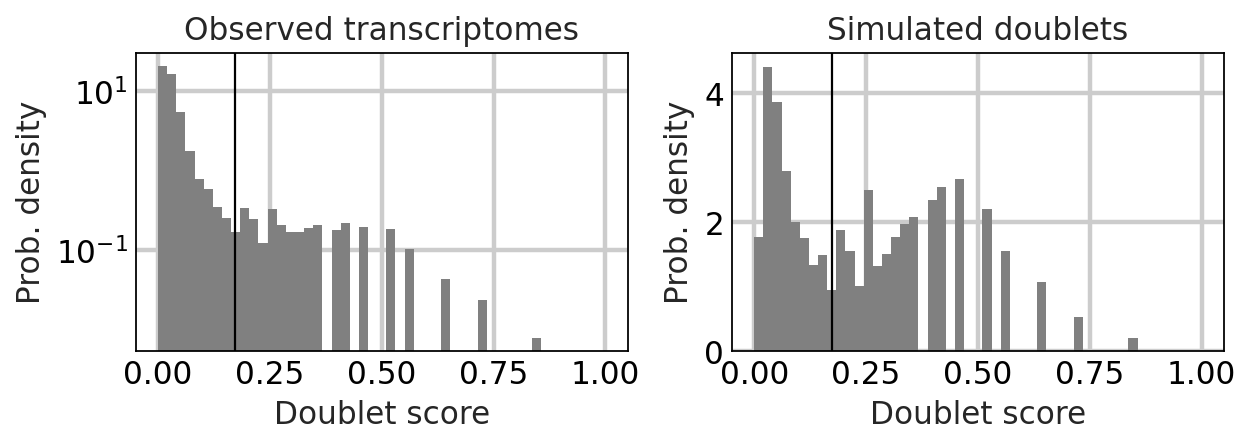

In [208]:
scrublet(adata_mm, expected_rate=0.06, doublet_score=.2)

In [210]:
adata_mm = adata_mm[np.invert(adata_mm.obs['predicted_doublets'])].copy()

In [213]:
adata_mm.layers["raw_counts"] = adata_mm.X.todense()

### Write output

In [214]:
adata_mm.write(adata_out_mm)
#adata_s.write(adata_out_s)

... storing 'DATASET' as categorical
... storing 'gene_ids' as categorical
... storing 'feature_types' as categorical
... storing 'chromosome' as categorical
